### Preprocessing

In [51]:
# import packages
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import os

# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import feature_extraction
from sklearn import svm, metrics, ensemble
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

In [60]:
# Parameter adjustment
seed = 42  # random state
test_size = 0.2  # test sample size

In [5]:
df = pd.read_json("/Users/deankuo/Desktop/python/DSSI_Final_project/591housing_tokenization_others.json") # TF-IDF dataset
df1 = pd.read_json("/Users/deankuo/Desktop/python/DSSI_Final_project/district.json") # District dataset
df1 = df1.rename(columns={"地址": "district_group"}).drop("index", axis=1) # Change column name and drop index
district = df1.to_numpy()
df.head(5)


,房價,坪數,price_per_size,冰箱,洗衣機,電視,冷氣,熱水器,床,衣櫃,第四台,網路,天然瓦斯,沙發,桌椅,陽台,電梯,車位,All_token
0,29500,15.00,1966.666667,1,1,0,1,1,1,1,0,1,0,1,1,0,0,0,"[可住, 可辦, 管理, 中山區, 最短, 租期, 一年, 隨時, 遷入, 不可, 養, 寵..."
1,65000,42.95,1513.387660,1,1,1,0,0,1,1,0,0,0,0,1,1,0,1,"[獨棟, 仁愛, 品藏, 電梯, 優質, 二房, 加, 車位, 大安區, 最短, 租期, 一..."
2,39000,17.00,2294.117647,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"[義大利, 設計, 宅大, 空間, 樓中樓, 含, 停車位, 信義區, 最短, 租期, 一年..."
3,11500,6.50,1769.230769,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,"[台大, 北教大, 溫馨, 麗緻, 雅房, 優選, 好屋, 大安區, 最短, 租期, 一年,..."
4,12800,12.00,1066.666667,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,"[師大, 商圈, 靜巷, 採光宅, 大安區, 最短, 租期, 一年, 隨時, 遷入, 房屋,..."


In [6]:
# I define houses that price_per_size > 1800 as expensive house and code it as 1
df.insert(2, column="district", value=district) 
df.insert(3, column="expensive_house", value=(df["price_per_size"] >= 1800).astype(int)) 
df["price_per_size"] = df["price_per_size"].round() # 四捨五入
print(f'Total number of houses that is more expensive than threshold: {df["expensive_house"].sum()}')  


Total number of houses that is more expensive than threshold: 4795


In [7]:
print(f'The average price per ping is: {df["price_per_size"].mean().round()}') # type: ignore

The average price per ping is: 1714.0


In [8]:
# 因為先前有將無效資料drop掉，但沒有處理到index，所以在這邊重新整理一次index
df.set_index("expensive_house", inplace=True)
df.reset_index(inplace=True)
df.head(5)

,expensive_house,房價,坪數,district,price_per_size,冰箱,洗衣機,電視,冷氣,熱水器,...,衣櫃,第四台,網路,天然瓦斯,沙發,桌椅,陽台,電梯,車位,All_token
0,1,29500,15.00,中山區,1967.0,1,1,0,1,1,...,1,0,1,0,1,1,0,0,0,"[可住, 可辦, 管理, 中山區, 最短, 租期, 一年, 隨時, 遷入, 不可, 養, 寵..."
1,0,65000,42.95,大安區,1513.0,1,1,1,0,0,...,1,0,0,0,0,1,1,0,1,"[獨棟, 仁愛, 品藏, 電梯, 優質, 二房, 加, 車位, 大安區, 最短, 租期, 一..."
2,1,39000,17.00,信義區,2294.0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,"[義大利, 設計, 宅大, 空間, 樓中樓, 含, 停車位, 信義區, 最短, 租期, 一年..."
3,0,11500,6.50,大安區,1769.0,1,1,1,1,1,...,1,1,1,1,0,1,0,0,0,"[台大, 北教大, 溫馨, 麗緻, 雅房, 優選, 好屋, 大安區, 最短, 租期, 一年,..."
4,0,12800,12.00,大安區,1067.0,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,"[師大, 商圈, 靜巷, 採光宅, 大安區, 最短, 租期, 一年, 隨時, 遷入, 房屋,..."


### TF-IDF

In [9]:
# 取得各房屋敘述的token
test_document = [" ".join(doc) for doc in df.All_token]

# Vectorization
vec = TfidfVectorizer(max_df=0.99, min_df=0.005) # type: ignore
X = vec.fit_transform(test_document)
tfidf_data = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out()) # type: ignore
tfidf_data.shape # dataframe shape

(12213, 1736)

In [10]:
# District data
tfidf_district_data = pd.concat([df1, df.expensive_house, df.price_per_size, tfidf_data], axis=1)
tfidf_district_data.head(5)

,district_group,expensive_house,price_per_size,10f,11f,12f,13f,14f,15f,16f,...,麥當勞,麻煩,黃先生,黃慶雄,黃金,黃金地段,點交,點開,齊全,龍山寺
0,中山區,1,1967.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,大安區,0,1513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,信義區,1,2294.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,大安區,0,1769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,大安區,0,1067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### District Classification

In [11]:
# Data overview
Counter(tfidf_district_data["district_group"])

Counter({'中山區': 2248,
         '大安區': 1794,
         '信義區': 1382,
         '松山區': 946,
         '北投區': 604,
         '內湖區': 1154,
         '中正區': 778,
         '大同區': 699,
         '文山區': 518,
         '萬華區': 642,
         '南港區': 436,
         '士林區': 1012})

In [77]:
# Define models
def create_models(seed):
    return {
        "Linear_SVM": svm.SVC(C=1, kernel="linear", random_state=seed),
        "RBF_SVM": svm.SVC(C=10, kernel="rbf", random_state=seed),
        "Multinomial_NB": MultinomialNB(alpha=1, fit_prior=True),
        "Random_Forest": RandomForestClassifier(n_estimators=800, random_state=seed),
    }

# Groupby districts
def get_grouped_data_and_keys(tfidf_district_data):
    grouped_by_district = tfidf_district_data.groupby(["district_group"])
    district_keys = grouped_by_district.groups.keys()
    return grouped_by_district, district_keys

# Important features of Linear SVM, Multinomial NB, and Random Forest
def get_important_features(model, X_train):
    if isinstance(model, MultinomialNB):
        coef = np.exp(model.feature_log_prob_)
        feature_importances = pd.Series(model.feature_log_prob_[1] - model.feature_log_prob_[0], index=X_train.columns)
        return feature_importances.abs().nlargest(10).index.tolist()
    else:
        if hasattr(model, 'coef_'):
            coef = pd.Series(model.coef_[0], index=X_train.columns) # type: ignore
            coef_abs = coef.abs().sort_values(ascending=False)
            return coef_abs.index.tolist()[:10]
        elif hasattr(model, 'feature_importances_'):
            importances = pd.Series(model.feature_importances_, index=X_train.columns) # type: ignore
            importances_abs = importances.abs().sort_values(ascending=False)
            return importances_abs.index.tolist()[:10]
        else:
            return []

def calculate_metrics(y_test, y_pred):
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    return precision, recall, f1

def process_model(model, grouped_by_district, district_keys):
    precision_list, recall_list, f1_list, district_list, important_features = [], [], [], [], []

    for district_key in district_keys:
        district_data = grouped_by_district.get_group(district_key)
        X = district_data.drop(["expensive_house", "district_group", "price_per_size"], axis=1)
        y = district_data["expensive_house"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

        model.fit(X_train, y_train)
        important_features.append(get_important_features(model, X_train))

        y_pred = model.predict(X_test)
        precision, recall, f1 = calculate_metrics(y_test, y_pred)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        district_list.append(district_key)

    df = pd.DataFrame({"District": district_list, "Precision": precision_list, "Recall": recall_list, "F1 Score": f1_list, "Important Features": important_features})
    df.set_index("District", inplace=True)
    return df

def create_reports(models, grouped_by_district, district_keys):
    precision_df, recall_df, f1score_df, important_features_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for name, model in models.items():
        df = process_model(model, grouped_by_district, district_keys)
        precision_df[f"{name}"] = df["Precision"]
        recall_df[f"{name}"] = df["Recall"]
        f1score_df[f"{name}"] = df["F1 Score"]
        important_features_df[name] = df["Important Features"]

    return precision_df, recall_df, f1score_df, important_features_df


In [82]:
def main():
    seed = 42
    test_size = 0.2
    models = create_models(seed)
    grouped_by_district, district_keys = get_grouped_data_and_keys(tfidf_district_data)
    precision_df, recall_df, f1score_df, important_features_df = create_reports(models, grouped_by_district, district_keys)

# Save or print the resulting dataframes as needed
print("Precision:\n", precision_df)
print("\nRecall:\n", recall_df)
print("\nF1 Score:\n", f1score_df)
print("\nImportant Features:\n", important_features_df)

if name == 'main':
    main()

Precision:
           Linear_SVM   RBF_SVM  Multinomial_NB  Random_Forest
District                                                     
中山區         0.662037  0.718593        0.673684       0.687805
中正區         0.535211  0.677966        0.448276       0.636364
信義區         0.790909  0.773913        0.733333       0.752294
內湖區         0.714286  0.677419        0.621622       0.837838
北投區         1.000000  0.714286        0.818182       1.000000
南港區         0.642857  0.631579        0.588235       0.533333
士林區         0.416667  0.428571        0.250000       0.454545
大同區         0.829787  0.857143        0.714286       0.880952
大安區         0.712707  0.767442        0.654054       0.750000
文山區         0.000000  0.200000        0.000000       0.500000
松山區         0.725806  0.676056        0.710145       0.762712
萬華區         0.681818  0.705882        0.777778       0.750000

Recall:
           Linear_SVM   RBF_SVM  Multinomial_NB  Random_Forest
District                                        

### Model Selection of Taipei City

In [83]:
# Train test split
y = tfidf_district_data["expensive_house"]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# SVM , Naive Bayes, and Random Forest model
models = {
    "Linear SVM": svm.SVC(C=1, kernel='linear'), # linear SVM
    "RBF SVM": svm.SVC(C=1, kernel='rbf'), # RBF SVM
    "Multinomial Naive Bayes": MultinomialNB(alpha=1, fit_prior=True), # Multinomial Naive Bayes
    "Random Forest": RandomForestClassifier(n_estimators=100), # Random Forest
}

results = {}
results_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score'])

for model_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    # Model results
    results[model_name] = {
        "precision": precision,
        "recall": recall,
        "f1 score": f1,
        "report": report,
        "confusion_matrix": confusion_matrix,
    }
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=[0])], ignore_index=True)

In [86]:
results_df.set_index('Model', inplace=True)
results_df

,Precision,Recall,F1 Score
Model,,,
Linear SVM,0.679204,0.614615,0.645297
RBF SVM,0.719905,0.604605,0.657236
Multinomial Naive Bayes,0.614130,0.452452,0.521037
Random Forest,0.736842,0.560561,0.636725


In [93]:
def tune_svm_linear(X_train, y_train):
    param_grid = {'C': [1, 3, 5, 7, 10], 'kernel': ['linear']}
    svm_linear = SVC()
    grid_search = GridSearchCV(svm_linear, param_grid, scoring='f1', cv=5, verbose=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def tune_svm_rbf(X_train, y_train):
    param_grid = {'C': [5, 6, 8, 10, 15], 'kernel': ['rbf']}
    svm_rbf = SVC()
    grid_search = GridSearchCV(svm_rbf, param_grid, scoring='f1', cv=5, verbose=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def tune_random_forest(X_train, y_train):
    param_grid = {'n_estimators': [100, 200, 400, 800, 1000]}
    random_forest = RandomForestClassifier()
    grid_search = GridSearchCV(random_forest, param_grid, scoring='f1', cv=5, verbose=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def tune_naive_bayes(X_train, y_train):
    param_grid = {'alpha': [0.01, 0.1, 0.2, 0.5, 1.0]}
    naive_bayes = MultinomialNB(fit_prior=True)
    grid_search = GridSearchCV(naive_bayes, param_grid, scoring='f1', cv=5, verbose=3)
    grid_search.fit(X_train, y_train)
    return grid_search

def hyperparameter_tuning(X_train, y_train, X_test):
    tuning_functions = {
        'svm_linear': tune_svm_linear,
        'svm_rbf': tune_svm_rbf,
        'random_forest': tune_random_forest,
        'naive_bayes': tune_naive_bayes,
    }

    results = {}
    y_pred = {}

    for name, tuning_function in tuning_functions.items():
        print(f"Performing hyperparameter tuning for {name}...")
        grid_search = tuning_function(X_train, y_train)
        results[name] = {'best_params': grid_search.best_params_, 'best_score': grid_search.best_score_}
        y_pred[name] = grid_search.predict(X_test)

    return results, y_pred

results, y_pred = hyperparameter_tuning(X_train, y_train, X_test)


Performing hyperparameter tuning for svm_linear...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.649 total time=  36.2s
[CV 2/5] END ................C=1, kernel=linear;, score=0.646 total time=  34.2s
[CV 3/5] END ................C=1, kernel=linear;, score=0.627 total time=  36.8s
[CV 4/5] END ................C=1, kernel=linear;, score=0.661 total time=  33.3s
[CV 5/5] END ................C=1, kernel=linear;, score=0.626 total time=  32.4s
[CV 1/5] END ................C=3, kernel=linear;, score=0.653 total time=  32.2s
[CV 2/5] END ................C=3, kernel=linear;, score=0.647 total time=  34.2s
[CV 3/5] END ................C=3, kernel=linear;, score=0.629 total time=  34.1s
[CV 4/5] END ................C=3, kernel=linear;, score=0.664 total time=  35.6s
[CV 5/5] END ................C=3, kernel=linear;, score=0.624 total time=  31.5s
[CV 1/5] END ................C=5, kernel=linear;, score=0.652 total time=  33.9

In [94]:
results

{'svm_linear': {'best_params': {'C': 3, 'kernel': 'linear'},
  'best_score': 0.6434826613108893},
 'svm_rbf': {'best_params': {'C': 15, 'kernel': 'rbf'},
  'best_score': 0.6723396075427208},
 'random_forest': {'best_params': {'n_estimators': 400},
  'best_score': 0.6206516430654746},
 'naive_bayes': {'best_params': {'alpha': 0.1},
  'best_score': 0.5411295488994133}}

In [95]:
optimal_clf = SVC(C=15, kernel='rbf')
optimal_clf.fit(X_train, y_train)
optimal_pred = optimal_clf.predict(X_test)
report = classification_report(y_test, optimal_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1444
           1       0.72      0.68      0.70       999

    accuracy                           0.76      2443
   macro avg       0.76      0.75      0.75      2443
weighted avg       0.76      0.76      0.76      2443



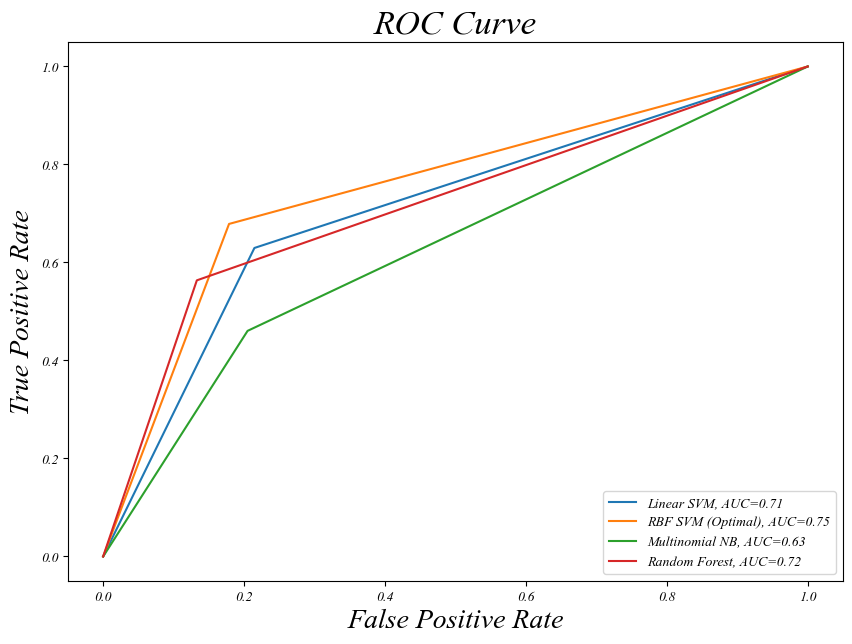

In [96]:
# Plotting ROC curve
plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['font.style'] = 'italic'

plt.figure(figsize=(10,7))

models = {
    'Linear SVM': y_pred['svm_linear'],
    'RBF SVM (Optimal)': y_pred['svm_rbf'],
    'Multinomial NB': y_pred['naive_bayes'],
    'Random Forest': y_pred['random_forest']
}

for model, y_pred in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{model}, AUC={auc:.2f}")

plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.title("ROC Curve", fontsize=25)
plt.legend(loc='lower right')
plt.savefig("ROC_curve.jpg", dpi=500)